In [1]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
import ipywidgets
from IPython.display import clear_output

In [2]:
df = pd.read_csv('Data_Cortex_Nuclear.csv')  

In [3]:
df.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [4]:
t = pd.Series(df.isna().sum())
t[t>100]

BAD_N        213
BCL2_N       285
H3AcK18_N    180
EGR1_N       210
H3MeK4_N     270
dtype: int64

В нашем датасете есть колонки (признаки), где отонсительно большое число пропусков (больше 180 при том, что всего 1080 строк). Это признаки: 'BAD_N', 'BCL2_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N'. Удалим эти колонки из нашего рассмотрения.

In [5]:
df.drop(columns=['BAD_N', 'BCL2_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N'],inplace=True)

In [6]:
len(t[(t>0) & (t < 100)])

44

In [7]:
len(df['MouseID'].unique())==len(df['MouseID'])

True

В строках также обнаружены пропуски (44 строки с небольшим количество пропусков в каждрй), их мы удалим (Заполнение их чем-то в данном случае трудно обосновать, но таких пропусков относительно мало).

Колонку MouseID можно удалить, так это просто нумерация для датасета. Так как id нигде не повторяется, делаем вывод что здесь нет измерении для одной и той же мыши, т.е. этот признак можно отбросить.

In [8]:
df.dropna(inplace=True)
df.drop(columns=['MouseID'],inplace=True)

In [9]:
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,pCFOS_N,SYP_N,CaNA_N,Genotype,Treatment,Behavior,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,0.394721,0.339571,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.106305,0.108336,0.427099,1.675652,Control,Memantine,C/S,c-CS-m
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,0.368255,0.321959,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.106592,0.104315,0.441581,1.743610,Control,Memantine,C/S,c-CS-m
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,0.363880,0.313086,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.108303,0.106219,0.435777,1.926427,Control,Memantine,C/S,c-CS-m
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,0.366771,0.328492,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.103184,0.111262,0.391691,1.700563,Control,Memantine,C/S,c-CS-m
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,0.351551,0.312206,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.481227,0.251773,1.534835,2.009109,0.119524,0.997775,0.878668,0.205604,0.104784,0.110694,0.434154,1.839730,Control,Memantine,C/S,c-CS-m


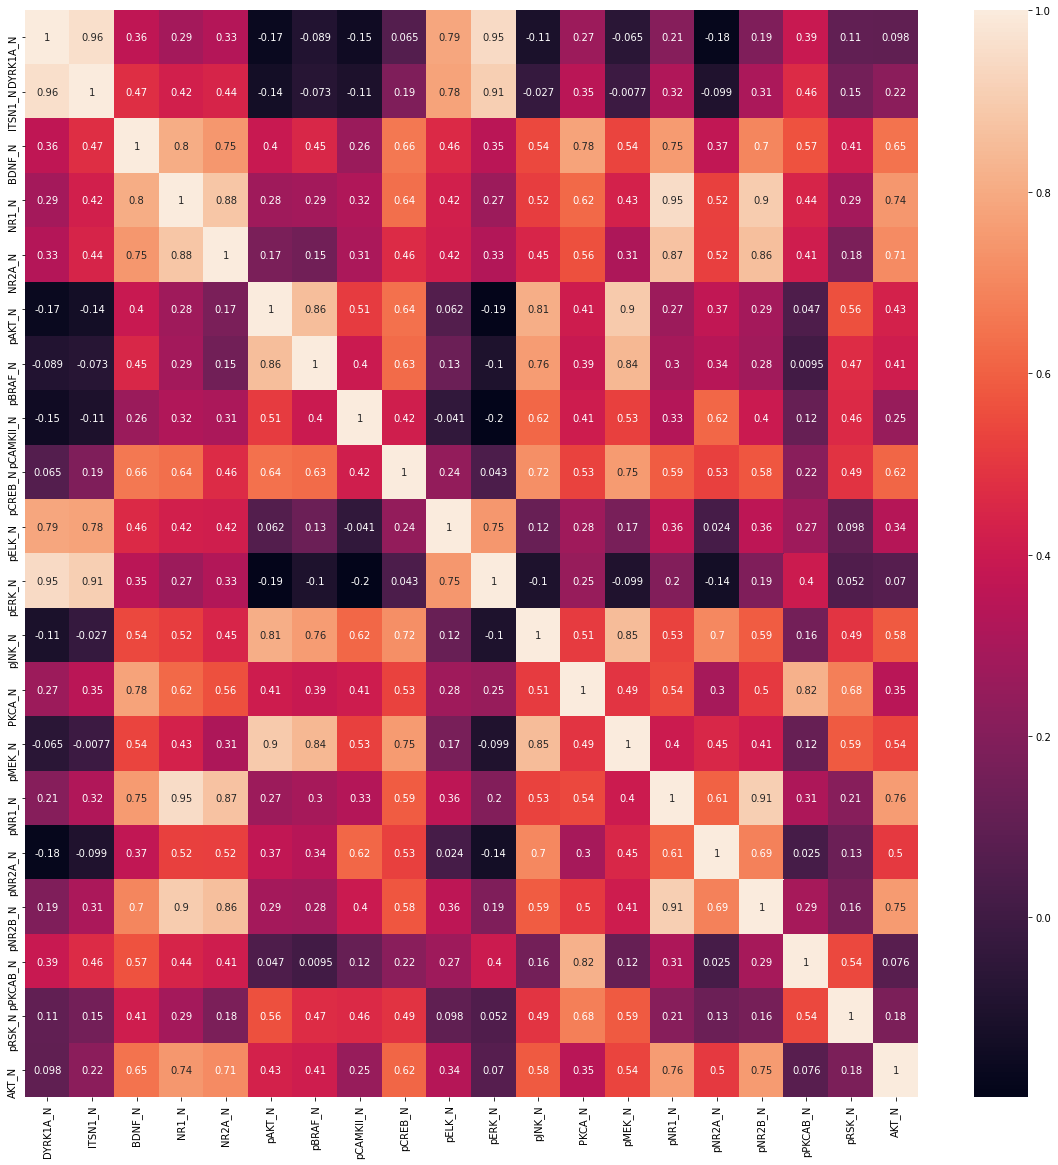

In [33]:
plt.figure(figsize = (20,20))
corr = df[df.columns[[i for i in range(20)]]].corr()
sns.heatmap(corr, annot = True)

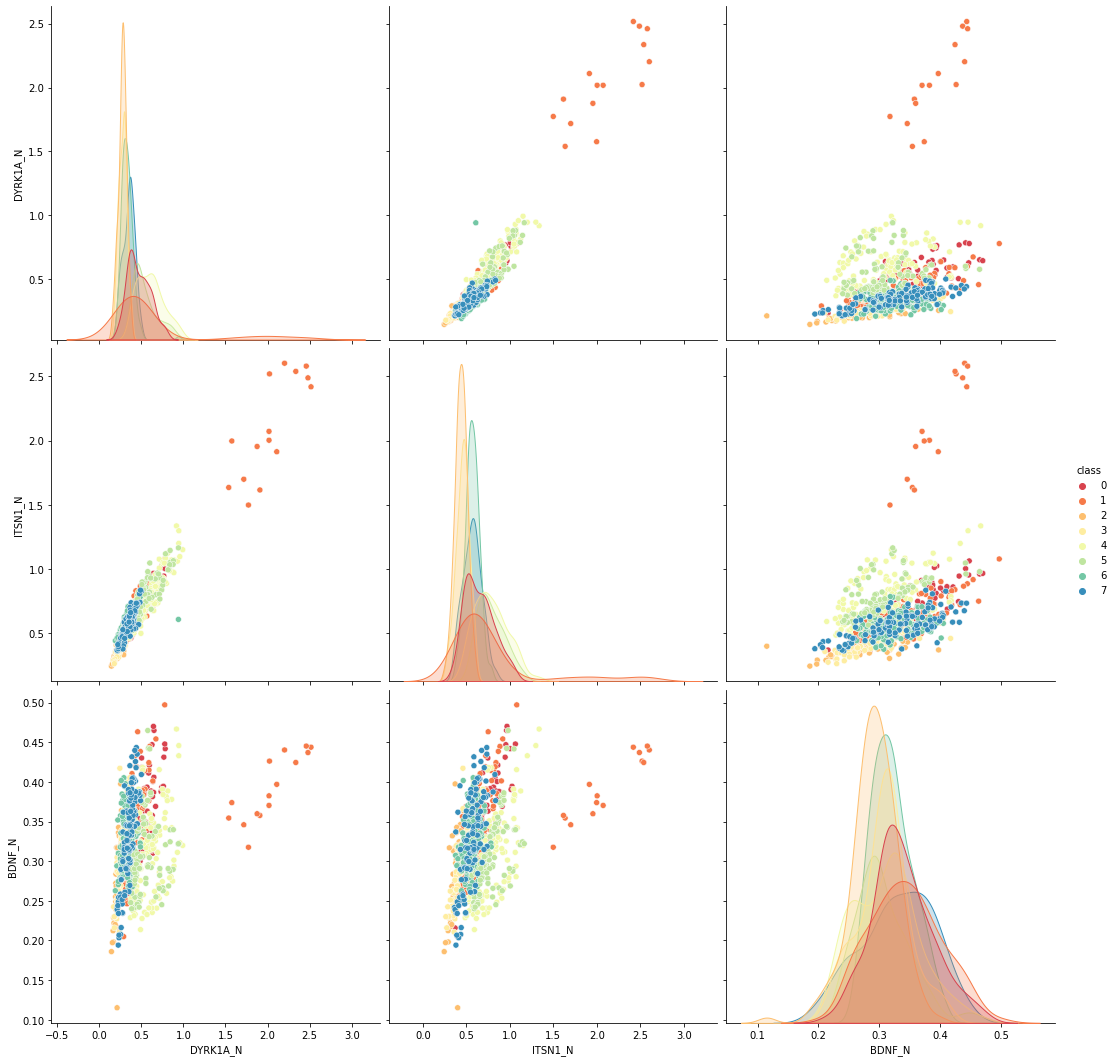

In [105]:
sns.pairplot(t, hue='class', palette=sns.color_palette("Spectral", n_colors=8),height=5)

In [97]:
t = df[df.columns[[i for i in range(3)]]].merge(df['class'],left_index=True, right_index=True)

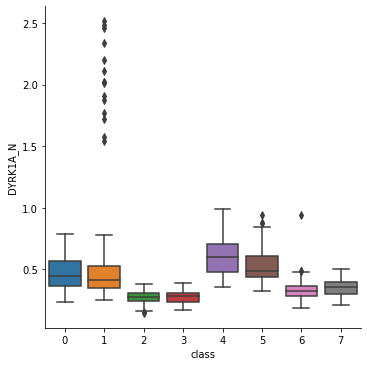

In [39]:
sns.catplot(x="class", y="DYRK1A_N", kind="box", data=df)

In [81]:
def draw_box_plot_per_class(col_i):
  clear_output()
  sns.catplot(x="class", y=df.columns[col_i], kind="box", data=df)

In [131]:
ipywidgets.interact(draw_box_plot_per_class, col_i = [i for i in range(72)])

interactive(children=(Dropdown(description='col_i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [10]:
df.select_dtypes(exclude=['int', 'float']).columns

Index(['Genotype', 'Treatment', 'Behavior', 'class'], dtype='object')

В нашем датасете есть 4 колонки с категориальными данными: 'Genotype', 'Treatment', 'Behavior', 'class'
Первые три переведем в числовое представление с помощью OneHotEncoder, метки класса просто занумеруем с помощью LabelEncoder 

In [15]:
from sklearn.preprocessing import LabelEncoder
df = pd.get_dummies(df, columns=['Genotype', 'Treatment', 'Behavior'])
enc = LabelEncoder()
df['class'] = enc.fit_transform(df['class'])

In [17]:
df["class"].value_counts()

2    150
6    135
4    120
3    120
1    120
0    120
7    117
5     90
Name: class, dtype: int64

Количество элементов выборки по классам не совсем сбалансированно.

In [107]:
feature_names = list(df.columns)
feature_names.remove('class')

In [112]:
X = df[feature_names]
y = df['class']
# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Train the scaler, which standarizes all the features to have mean=0 and unit variance
sc = StandardScaler()
sc.fit(X_train)
# Apply the scaler to the X training data
X_train_std = sc.transform(X_train)

# Apply the SAME scaler to the X test data
X_test_std = sc.transform(X_test)

In [ ]:
max_iter = 3500,eta0=0.00001,tol=None, penalty='l2'

In [128]:
# Create a perceptron object with the parameters: 40 iterations (epochs) over the data, and a learning rate of 0.1
ppn = Perceptron()

# Train the perceptron
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [124]:
# Apply the trained perceptron on the X data to make predicts for the y test data
y_pred = ppn.predict(X_test_std)
# View the accuracy of the model, which is: 1 - (observations predicted wrong / total observations)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 1.00


In [212]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=1000,tol = 0.000000001).fit(X_train_std[:,(40,44)], y_train)
y_pred = clf.predict(X_test_std[:,(70,60)])
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.15


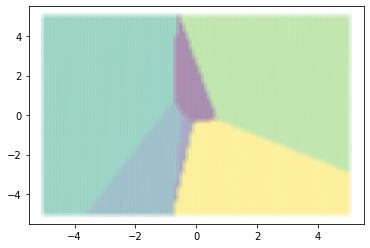

In [213]:
a = 40
b = 44
plt.figure()                       
X_d = np.zeros(shape=(10000,2))
y_d = np.zeros(shape=(10000))
draw = np.zeros(shape=X_d.shape[1])
count = 0
m = X_test_std[0,(a,b)]
for x in np.linspace(-5.0,5, 100):
    for s in np.linspace(-5,5, 100):
      
      X_d[count,0]=x
      X_d[count,1]=s
      m[0] = x
      m[1] = s
      y_d[count] = clf.predict(m.reshape(1, 2))[0]
      count += 1

plt.scatter(X_d[:,0], X_d[:,1], c=y_d, alpha = 0.07)
#plt.scatter(X_train_std[:,a], X_train_std[:,b], c=y_train,alpha = 1.0)
plt.show()

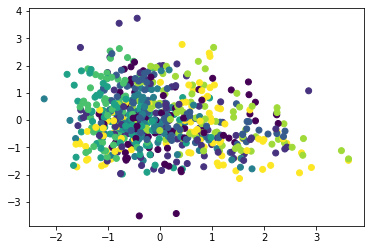

In [214]:
plt.scatter(X_train_std[:,a], X_train_std[:,b], c=y_train,alpha = 1.0)
plt.show()


In [147]:
xx, yy = np.mgrid[-2:2:.01, -2:2:.01]

In [148]:
xx

array([[-2.  , -2.  , -2.  , ..., -2.  , -2.  , -2.  ],
       [-1.99, -1.99, -1.99, ..., -1.99, -1.99, -1.99],
       [-1.98, -1.98, -1.98, ..., -1.98, -1.98, -1.98],
       ...,
       [ 1.97,  1.97,  1.97, ...,  1.97,  1.97,  1.97],
       [ 1.98,  1.98,  1.98, ...,  1.98,  1.98,  1.98],
       [ 1.99,  1.99,  1.99, ...,  1.99,  1.99,  1.99]])

In [ ]:
y_pred

In [3]:
df2 = pd.read_csv('abalone.csv') 
df2.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
pd.Series(df2.isna().sum())

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

В датасете Abalone нет пропущенных значенний

Классы очень несбалансированны

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



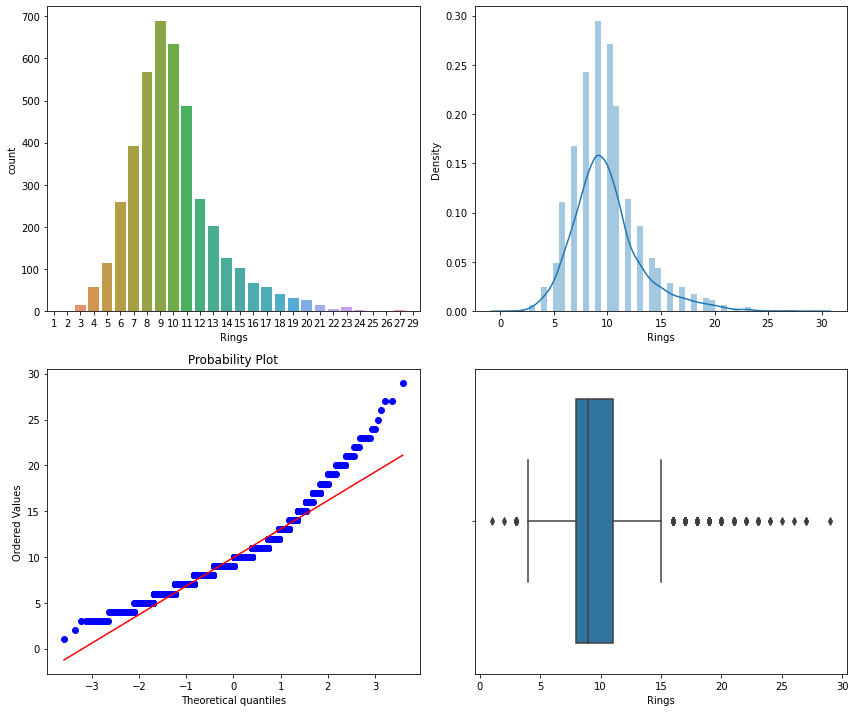

In [19]:
from scipy import stats
plt.figure(figsize=(12, 10))

plt.subplot(2,2,1)
sns.countplot(df.Rings)

plt.subplot(2,2,2)
sns.distplot(df2.Rings)

plt.subplot(2,2,3)
stats.probplot(df.Rings, plot=plt)

plt.subplot(2,2,4)
sns.boxplot(df.Rings) 

plt.tight_layout()

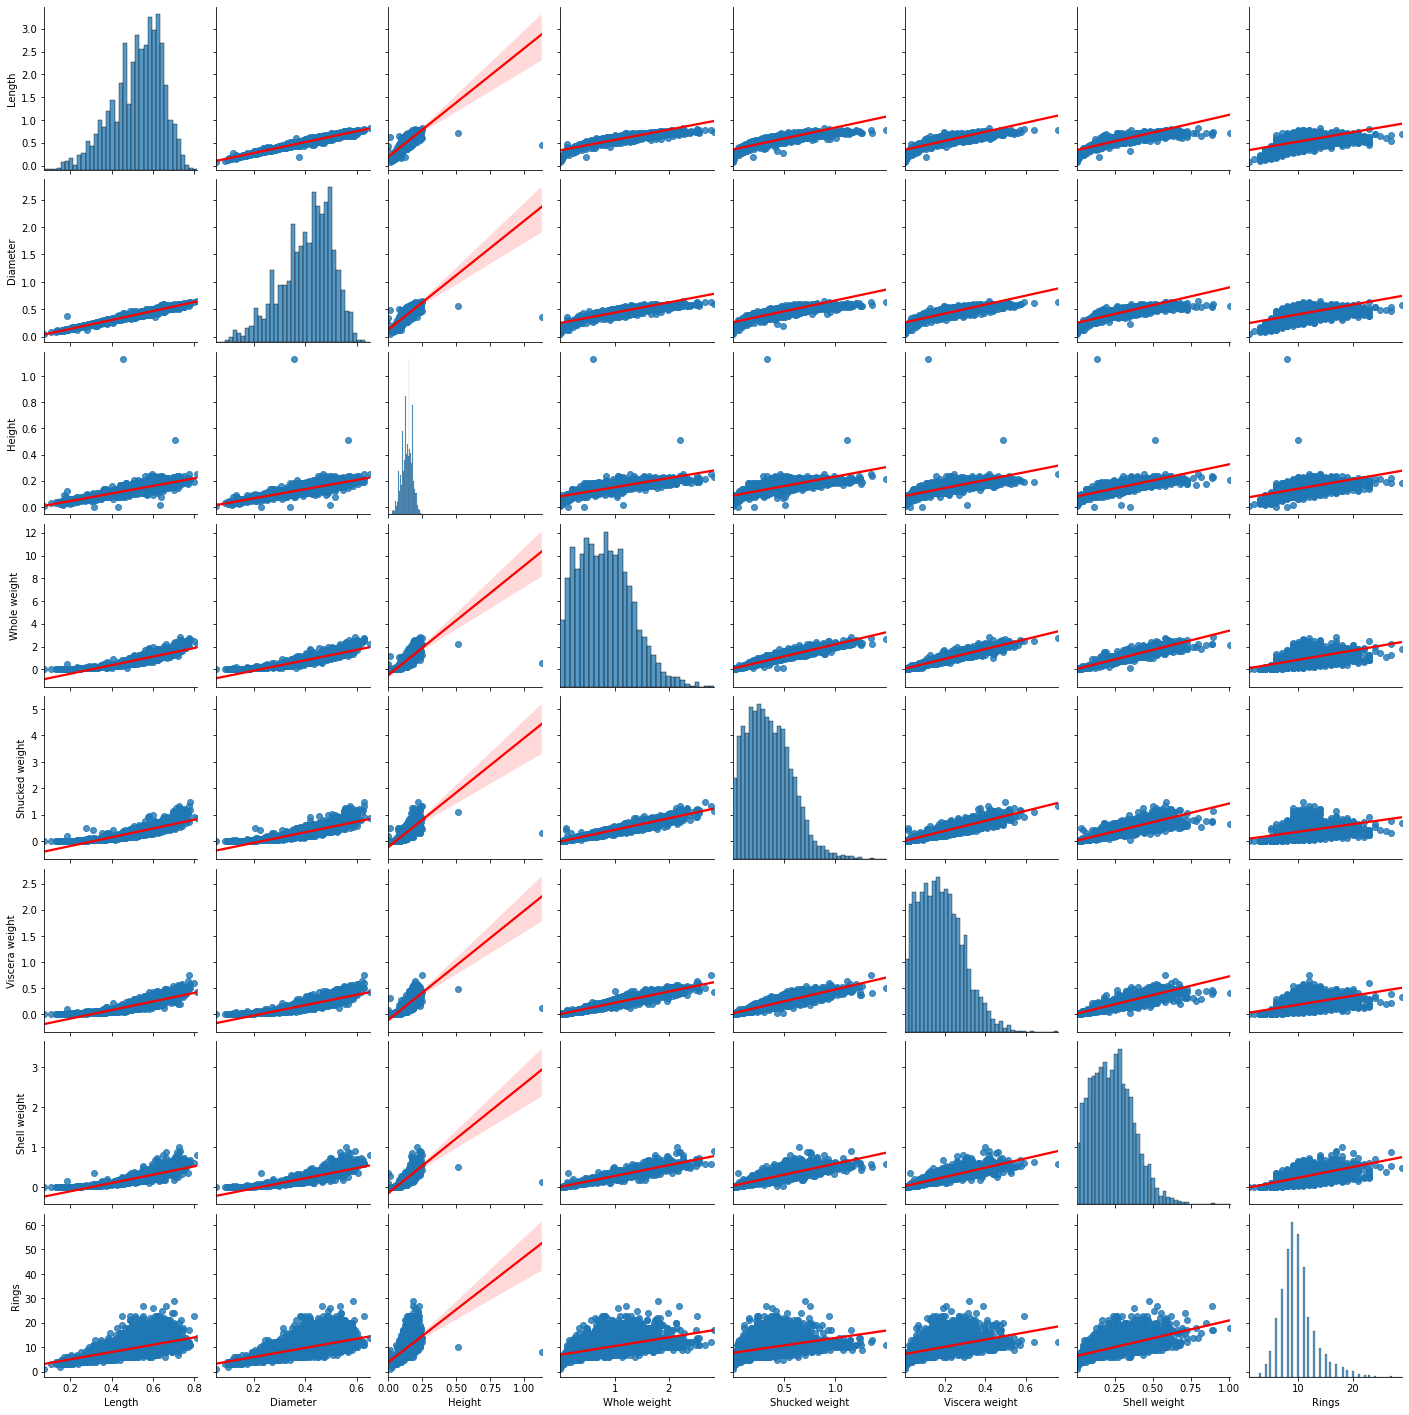

In [40]:
sns.pairplot(df2.drop(['Sex'], axis=1),kind='reg',plot_kws={'line_kws':{'color':'red'}})

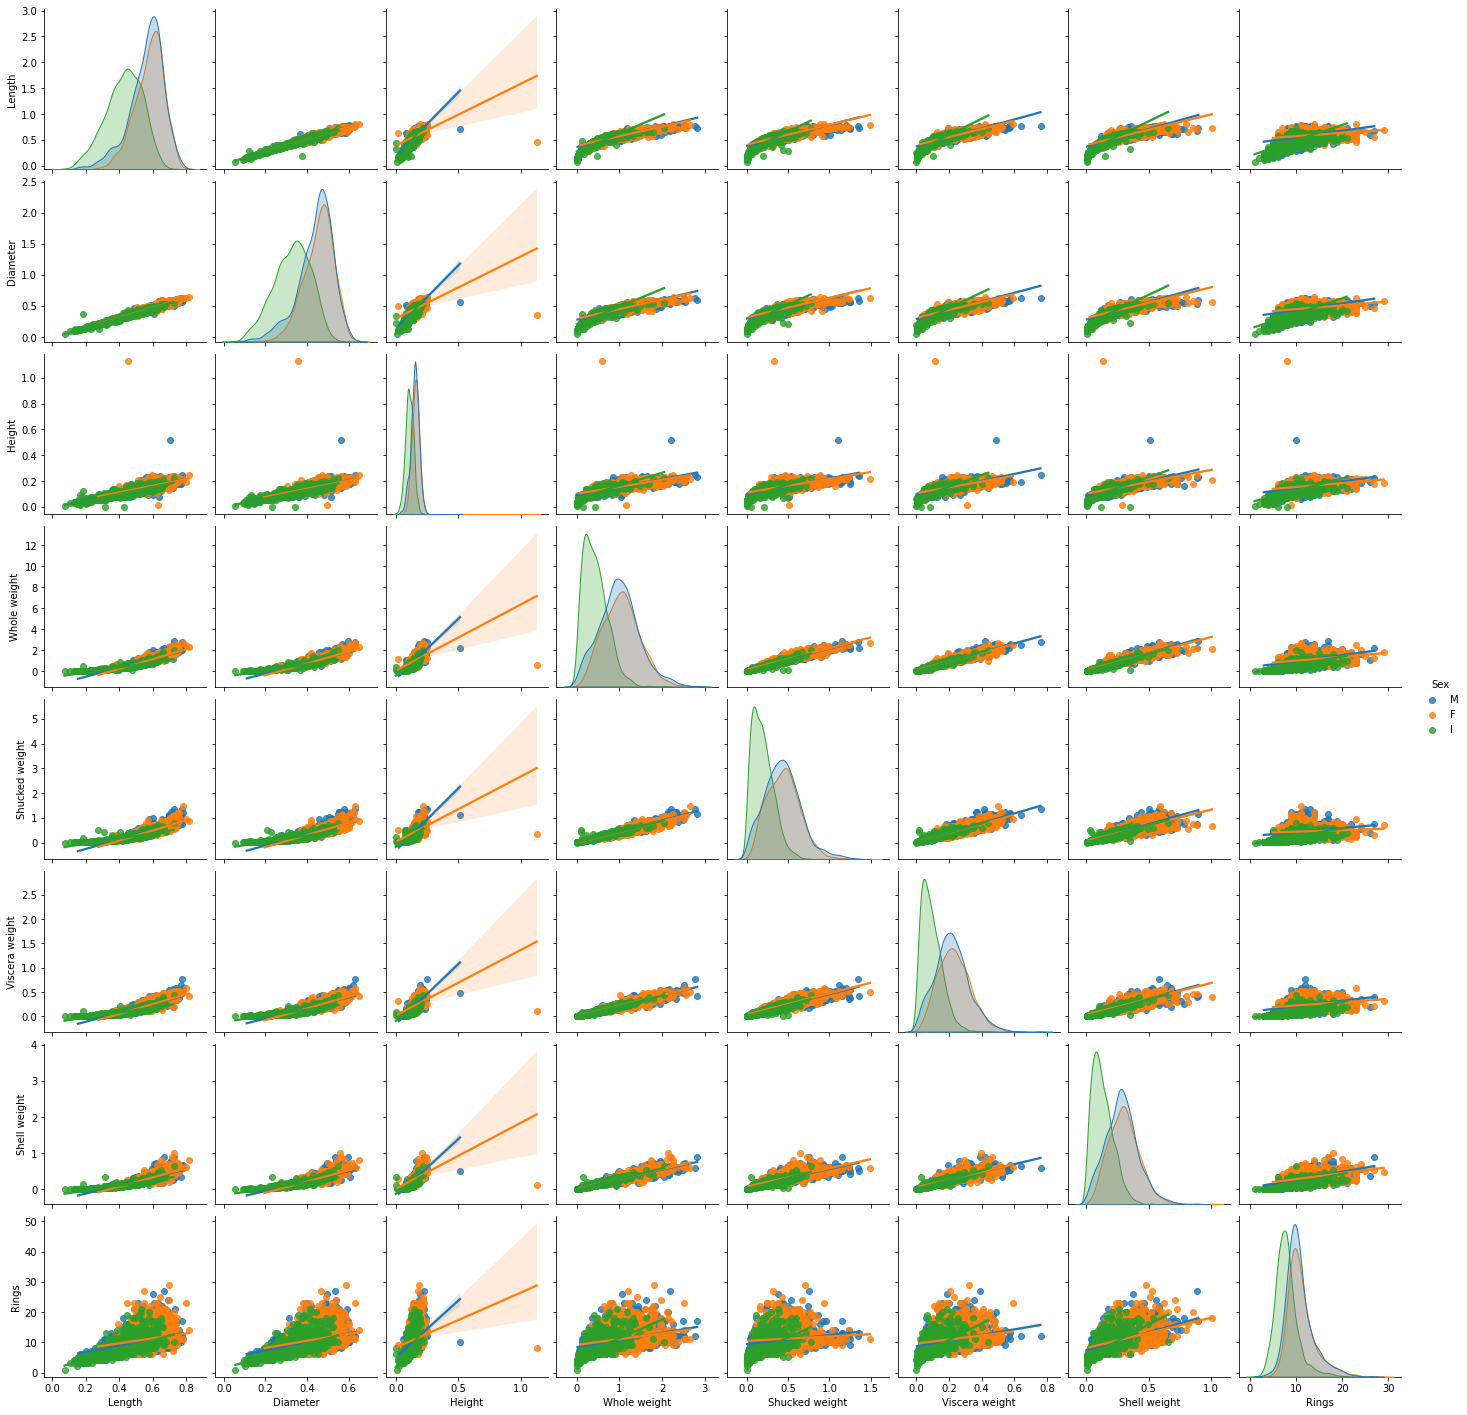

In [37]:
sns.pairplot(df2, hue='Sex',kind='reg' )

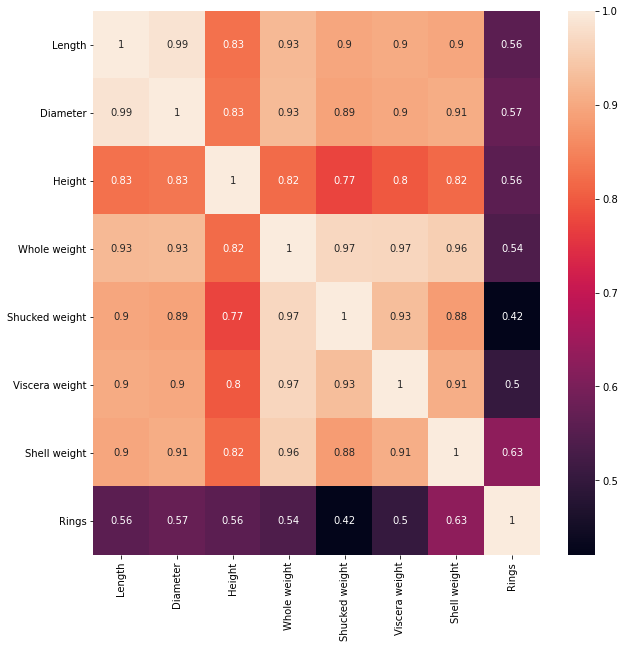

In [24]:
plt.figure(figsize = (10,10))
corr = df2.corr()
sns.heatmap(corr, annot = True)

In [34]:
df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in df2.drop(columns=['Sex']).columns:
    for y in df2.drop(columns=['Sex']).columns:
        corr = stats.pearsonr(df2[x], df2[y])
        df_corr.loc[x,y] = corr[0]
        df_p.loc[x,y] = corr[1]

In [36]:
df_p

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Length,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
Diameter,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
Height,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
Whole weight,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.888678e-315
Shucked weight,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,5.087464e-179
Viscera weight,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.574726e-268
Shell weight,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
Rings,0.0,0.0,0.0,1.888678e-315,5.087464e-179,8.574726e-268,0.0,0.000000e+00


In [41]:
from sklearn.preprocessing import LabelEncoder
df2 = pd.get_dummies(df2, columns=['Sex'])
enc = LabelEncoder()
df2['Rings'] = enc.fit_transform(df['Rings'])

In [45]:
feature_names = list(df2.columns)
feature_names.remove('Rings')
X = df2[feature_names]
y = df2['Rings']
# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Train the scaler, which standarizes all the features to have mean=0 and unit variance
sc = StandardScaler()
sc.fit(X_train)
# Apply the scaler to the X training data
X_train_std = sc.transform(X_train)

# Apply the SAME scaler to the X test data
X_test_std = sc.transform(X_test)

In [46]:
# Create a perceptron object with the parameters: 40 iterations (epochs) over the data, and a learning rate of 0.1
ppn = Perceptron()

# Train the perceptron
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
# Apply the trained perceptron on the X data to make predicts for the y test data
y_pred = ppn.predict(X_test_std)
# View the accuracy of the model, which is: 1 - (observations predicted wrong / total observations)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.20


In [91]:
a = 4
b = 6
#[:,[a,b]]
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=30000,class_weight="balanced").fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.21


In [100]:
df2.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,14,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,6,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,8,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,9,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,6,0,1,0


In [99]:
df_1 = df2.copy()
Age = []
for i in df_1["Rings"]:
    if i <= 5:
        Age.append("1")
    if i >= 6 and i <= 10 :
        Age.append("2")
    if i >= 11 and i <= 15 :
        Age.append("3")
    if i >= 16 and i <= 20 :
        Age.append("4")
    if i > 20:
        Age.append("5")
df_1["Age"] = Age
df_1.drop("Rings" , axis =1,inplace=True)
df_1.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M,Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1,3
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1,2
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0,2
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1,2
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0,2


In [101]:
feature_names = list(df_1.columns)
feature_names.remove('Age')

X = df_1[feature_names]
y = df_1['Age']
# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Train the scaler, which standarizes all the features to have mean=0 and unit variance
sc = StandardScaler()
sc.fit(X_train)
# Apply the scaler to the X training data
X_train_std = sc.transform(X_train)

# Apply the SAME scaler to the X test data
X_test_std = sc.transform(X_test)

In [177]:
# Create a perceptron object with the parameters: 40 iterations (epochs) over the data, and a learning rate of 0.1
ppn = Perceptron(eta0=0.000005, max_iter=3500, tol=None, penalty='l2')

# Train the perceptron
ppn.fit(X_train_std, y_train)
# Apply the trained perceptron on the X data to make predicts for the y test data
y_pred = ppn.predict(X_test_std)
# View the accuracy of the model, which is: 1 - (observations predicted wrong / total observations)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred)

Accuracy: 0.66


In [191]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
learning_curve(ppn, X_train_std, y_train)

(array([ 233,  759, 1285, 1811, 2338]),
 array([[0.64377682, 0.67381974, 0.67381974, 0.67381974, 0.67381974],
        [0.60342556, 0.64690382, 0.65612648, 0.65612648, 0.65612648],
        [0.64046693, 0.60933852, 0.71050584, 0.66536965, 0.66536965],
        [0.69409166, 0.65323026, 0.54334622, 0.68912203, 0.58365544],
        [0.63601369, 0.66552609, 0.61120616, 0.69974337, 0.63002566]]),
 array([[0.62905983, 0.65470085, 0.65811966, 0.6489726 , 0.6489726 ],
        [0.56410256, 0.59316239, 0.66324786, 0.67294521, 0.64554795],
        [0.64102564, 0.56923077, 0.71794872, 0.68493151, 0.66780822],
        [0.70940171, 0.61880342, 0.57264957, 0.68835616, 0.56164384],
        [0.63931624, 0.66324786, 0.5982906 , 0.68493151, 0.64383562]]))

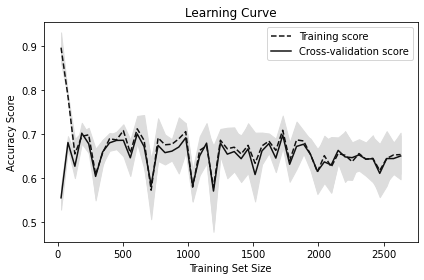

In [196]:
train_sizes, train_scores, test_scores = learning_curve(ppn, X_train_std, y_train,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [158]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=30000,tol=1e-17, C=1.8).fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.73


In [159]:
y_test==y_pred

3677     True
2021     True
2412     True
3473     True
1696     True
        ...  
3754     True
2095     True
3729     True
3791     True
370     False
Name: Age, Length: 1254, dtype: bool

In [130]:
y_test.values.astype(int)

array([2, 2, 2, ..., 2, 2, 3])

[4. 1. 2.]


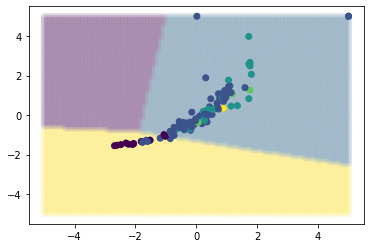

In [186]:
a = 0
b = 4
plt.figure()                       
X_d = np.zeros(shape=(10000,2))
y_d = np.zeros(shape=(10000))
draw = np.zeros(shape=X_d.shape[1])
count = 0
m = X_test_std[110]
for x in np.linspace(-5.0,5, 100):
    for s in np.linspace(-5,5, 100):
      
      X_d[count,0]=x
      X_d[count,1]=s
      m[a] = x
      m[b] = s
      y_d[count] = ppn.predict(m.reshape(1, 10))[0]
      count += 1
print(pd.Series(y_d).unique())
plt.scatter(X_d[:,0], X_d[:,1], c=y_d, alpha = 0.07)
plt.scatter(X_test_std[:100,a], X_test_std[:100,b], c=y_test.values.astype(int)[:100],alpha = 1.0)
plt.show()

In [183]:
y_test.unique()

array(['2', '1', '3', '4', '5'], dtype=object)

[4. 3. 2.]


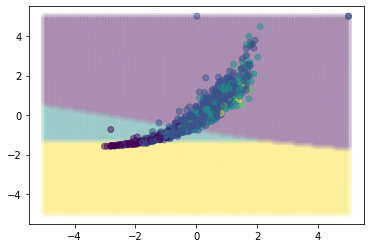

In [162]:
a = 0
b = 4
plt.figure()                       
X_d = np.zeros(shape=(10000,2))
y_d = np.zeros(shape=(10000))
draw = np.zeros(shape=X_d.shape[1])
count = 0
m = X_test_std[6]
for x in np.linspace(-5.0,5, 100):
    for s in np.linspace(-5,5, 100):
      
      X_d[count,0]=x
      X_d[count,1]=s
      m[a] = x
      m[b] = s
      y_d[count] = clf.predict(m.reshape(1, 10))[0]
      count += 1
print(pd.Series(y_d).unique())
plt.scatter(X_d[:,0], X_d[:,1], c=y_d, alpha = 0.07)
plt.scatter(X_test_std[:,a], X_test_std[:,b], c=y_test.values.astype(int),alpha = 0.5)
plt.show()